In [233]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
import emoji
from pprint import pprint
import collections
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib
from sklearn.svm import LinearSVC
import gensim
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')
np.random.seed(37)

In [197]:
train_data=pd.read_csv(r"C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\HackerRank - Mothers Day\train.csv")
test_data=pd.read_csv(r"C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\HackerRank - Mothers Day\test.csv")

In [198]:
train_data.head()

,id,original_text,lang,retweet_count,original_author,sentiment_class
0,1.245025e+18,Happy #MothersDay to all you amazing mothers out there! I know it's hard not being able to see your mothers today but it's on all of us to do what we can to protect the most vulnerable members of our society. #BeatCoronaVirus pic.twitter.com/va4nFjFQ5B,en,0,BeenXXPired,0
1,1.245759e+18,Happy Mothers Day Mum - I'm sorry I can't be there to bring you Mothers day flowers & a cwtch - honestly at this point I'd walk on hot coals to be able to. But I'll be there with bells on as soon as I can be. Love you lots xxx (p.s we need more photos!) https:// photos.app.goo.gl/M3vXBLrsCzD4TE bY7 …,en,1,FestiveFeeling,0
2,1.246087e+18,"Happy mothers day To all This doing a mothers days work. Today been quiet but Had time to reflect. Dog walk, finish a jigsaw do the garden, learn few more guitar chords, drunk some strawberry gin and tonic and watch Lee evens on DVD. My favourite place to visit. #isolate pic.twitter.com/GZ0xVvF6f9",en,0,KrisAllenSak,-1
3,1.244803e+18,Happy mothers day to this beautiful woman...royalty soothes you mummy jeremy and emerald and more #PrayForRoksie #UltimateLoveNG pic.twitter.com/oeetI22Pvv,en,0,Queenuchee,0
4,1.244876e+18,"Remembering the 3 most amazing ladies who made me who I am! My late grandmother iris, mum carol and great grandmother Ethel. Missed but never forgotten! Happy mothers day to all those great mums out there! Love sent to all xxxx pic.twitter.com/xZZZdEybjE",en,0,brittan17446794,-1


In [199]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3235 entries, 0 to 3234
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3235 non-null   float64
 1   original_text    3235 non-null   object 
 2   lang             3231 non-null   object 
 3   retweet_count    3231 non-null   object 
 4   original_author  3235 non-null   object 
 5   sentiment_class  3235 non-null   int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 151.8+ KB


In [200]:
temp = train_data.groupby('sentiment_class').count()['original_text'].reset_index().sort_values(by='original_text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment_class,original_text
1,0,1701
0,-1,769
2,1,765


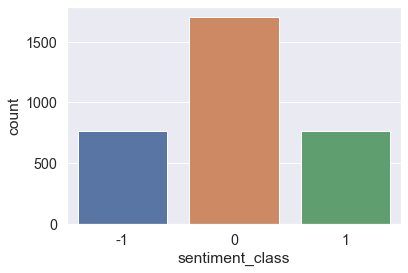

In [201]:
sns.countplot(x='sentiment_class',data=train_data)

In [202]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return df

In [203]:
tc = TextCounts()
df_eda = tc.fit_transform(train_data.original_text)
train_data=pd.concat([train_data,df_eda],axis=1)

In [204]:
train_data.head()

,id,original_text,lang,retweet_count,original_author,sentiment_class,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis
0,1.245025e+18,Happy #MothersDay to all you amazing mothers out there! I know it's hard not being able to see your mothers today but it's on all of us to do what we can to protect the most vulnerable members of our society. #BeatCoronaVirus pic.twitter.com/va4nFjFQ5B,en,0,BeenXXPired,0,48,0,2,0,1,0,0
1,1.245759e+18,Happy Mothers Day Mum - I'm sorry I can't be there to bring you Mothers day flowers & a cwtch - honestly at this point I'd walk on hot coals to be able to. But I'll be there with bells on as soon as I can be. Love you lots xxx (p.s we need more photos!) https:// photos.app.goo.gl/M3vXBLrsCzD4TE bY7 …,en,1,FestiveFeeling,0,65,0,0,0,1,0,0
2,1.246087e+18,"Happy mothers day To all This doing a mothers days work. Today been quiet but Had time to reflect. Dog walk, finish a jigsaw do the garden, learn few more guitar chords, drunk some strawberry gin and tonic and watch Lee evens on DVD. My favourite place to visit. #isolate pic.twitter.com/GZ0xVvF6f9",en,0,KrisAllenSak,-1,54,0,1,1,0,0,0
3,1.244803e+18,Happy mothers day to this beautiful woman...royalty soothes you mummy jeremy and emerald and more #PrayForRoksie #UltimateLoveNG pic.twitter.com/oeetI22Pvv,en,0,Queenuchee,0,22,0,2,0,0,0,0
4,1.244876e+18,"Remembering the 3 most amazing ladies who made me who I am! My late grandmother iris, mum carol and great grandmother Ethel. Missed but never forgotten! Happy mothers day to all those great mums out there! Love sent to all xxxx pic.twitter.com/xZZZdEybjE",en,0,brittan17446794,-1,45,0,0,0,3,0,0


In [205]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('sentiment_class')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='sentiment_class', size=5, hue='sentiment_class', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()

In [206]:
class CleanText(BaseEstimator, TransformerMixin):
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)
    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X

In [207]:
ct = CleanText()
train_data['original_text'] = ct.fit_transform(train_data.original_text)

In [209]:
train_data['temp_list'] = train_data['original_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train_data['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,mother,3936
1,day,3830
2,happi,3471
3,com,2602
4,mothersday,1876
5,twitter,1705
6,mum,1693
7,pic,1593
8,love,1290
9,instagram,835


In [210]:
train_data["clean_text"]= train_data["original_text"].str.replace("mum", "mother", case = False)
train_data["clean_text"]= train_data["clean_text"].str.replace("mom", "mother", case = False)
train_data["clean_text"]= train_data["clean_text"].str.replace("mothersday","mother day") 
train_data["clean_text"]= train_data["clean_text"].str.replace("httpswww","") 
train_data["clean_text"]= train_data["clean_text"].str.replace("http","") 
train_data["clean_text"]= train_data["clean_text"].str.replace("u","") 

In [211]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols
    def transform(self, X, **transform_params):
        return X[self.cols]
    def fit(self, X, y=None, **fit_params):
        return self

In [212]:
X_train, X_test, y_train, y_test = train_test_split(train_data.drop(['id','original_text','sentiment_class','lang','original_author'],axis=1), train_data.sentiment_class, test_size=0.2, random_state=37)

In [213]:
# Based on http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html
def grid_vect(clf, parameters_clf, X_train, X_test, parameters_text=None, vect=None, is_w2v=False):
    
    textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
                      ,'count_mentions','count_urls','count_words']
    
    if is_w2v:
        w2vcols = []
        for i in range(SIZE):
            w2vcols.append(i)
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('w2v', ColumnExtractor(cols=w2vcols))]
                                , n_jobs=-1)
    else:
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')), ('vect', vect)]))]
                                , n_jobs=-1)
    
    pipeline = Pipeline([
        ('features', features)
        , ('clf', clf)
    ])
    
    # Join the parameters dictionaries together
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)
    # Make sure you have scikit-learn version 0.19 or higher to use multiple scoring metrics
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)
    
    print("Performing grid search...")
    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()
    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
                        
    return grid_search

In [214]:
# Parameter grid settings for the vectorizers (Count and TFIDF)
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2),(1,3)),
    'features__pipe__vect__min_df': (1,2)
}
# Parameter grid settings for MultinomialNB
parameters_mnb = {
    'clf__alpha': (0.25, 0.5, 0.75)
}
# Parameter grid settings for LogisticRegression
parameters_logreg = {
    'clf__C': (0.25, 0.5, 1.0),
    'clf__penalty': ('l1', 'l2')
}

In [215]:
mnb = MultinomialNB()
logreg = LogisticRegression()

In [216]:
countvect = CountVectorizer()
# MultinomialNB
best_mnb_countvect = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=countvect)
# LogisticRegression
best_logreg_countvect = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=countvect)


Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2), (1, 3))}
Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 185 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   39.3s finished


done in 41.981s

Best CV score: 0.524
Best parameters set:
	clf__alpha: 0.75
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.519


Classification Report Test Data
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       160
           0       0.52      0.99      0.68       339
           1       0.25      0.01      0.03       148

    accuracy                           0.52       647
   macro avg       0.26      0.33      0.24       647
weighted avg       0.33      0.52      0.36       647

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2), (1, 3))}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  3.9min finished


done in 243.654s

Best CV score: 0.482
Best parameters set:
	clf__C: 0.25
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 3)
Test score with best_estimator_: 0.453


Classification Report Test Data
              precision    recall  f1-score   support

          -1       0.18      0.06      0.09       160
           0       0.51      0.80      0.62       339
           1       0.21      0.08      0.12       148

    accuracy                           0.45       647
   macro avg       0.30      0.31      0.27       647
weighted avg       0.36      0.45      0.37       647



In [217]:
prediction_logreg = best_logreg_countvect.predict(X_test)
prediction_mnb=best_mnb_countvect.predict(X_test)

In [218]:
mnb_score=100*(f1_score(y_test,prediction_mnb,average='weighted'))
logreg_score=100*(f1_score(y_test,prediction_logreg,average='weighted'))

In [219]:
print("\nAccuracy score of Multinomial naive bayes algorithm -----> " + str(mnb_score))
print("\nAccuracy score of Log Reg algorithm -----> " + str(logreg_score))


Accuracy score of Multinomial naive bayes algorithm -----> 36.410800773840016

Accuracy score of Log Reg algorithm -----> 37.2755037490733


In [220]:
SIZE = 50
X_train['clean_text_wordlist'] = X_train.clean_text.apply(lambda x : word_tokenize(x))
X_test['clean_text_wordlist'] = X_test.clean_text.apply(lambda x : word_tokenize(x))
model = gensim.models.Word2Vec(X_train.clean_text_wordlist, min_count=1, size=SIZE, window=5, workers=4)


In [221]:
def compute_avg_w2v_vector(w2v_dict, tweet):
    list_of_word_vectors = [w2v_dict[w] for w in tweet if w in w2v_dict.vocab.keys()]
    
    if len(list_of_word_vectors) == 0:
        result = [0.0]*SIZE
    else:
        result = np.sum(list_of_word_vectors, axis=0) / len(list_of_word_vectors)
        
    return result
X_train_w2v = X_train['clean_text_wordlist'].apply(lambda x: compute_avg_w2v_vector(model.wv, x))
X_test_w2v = X_test['clean_text_wordlist'].apply(lambda x: compute_avg_w2v_vector(model.wv, x))

In [222]:
X_train_w2v = pd.DataFrame(X_train_w2v.values.tolist(), index= X_train.index)
X_test_w2v = pd.DataFrame(X_test_w2v.values.tolist(), index= X_test.index)
# Concatenate with the TextCounts variables
X_train_w2v = pd.concat([X_train_w2v, X_train.drop(['clean_text', 'clean_text_wordlist'], axis=1)], axis=1)
X_test_w2v = pd.concat([X_test_w2v, X_test.drop(['clean_text', 'clean_text_wordlist'], axis=1)], axis=1)

In [223]:
best_logreg_w2v = grid_vect(logreg, parameters_logreg, X_train_w2v, X_test_w2v, is_w2v=True)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0), 'clf__penalty': ('l1', 'l2')}
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.7s finished


done in 2.212s

Best CV score: 0.527
Best parameters set:
	clf__C: 0.25
	clf__penalty: 'l2'
Test score with best_estimator_: 0.524


Classification Report Test Data
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       160
           0       0.52      1.00      0.69       339
           1       0.00      0.00      0.00       148

    accuracy                           0.52       647
   macro avg       0.17      0.33      0.23       647
weighted avg       0.27      0.52      0.36       647



In [224]:
prediction_w2v_logreg=best_logreg_w2v.predict(X_test_w2v)
logreg_w2v_score=100*(f1_score(y_test,prediction_w2v_logreg,average='weighted'))
print("\nAccuracy score of Log Reg algorithm -----> " + str(logreg_score))


Accuracy score of Log Reg algorithm -----> 37.2755037490733


In [231]:
# Parameter grid settings for the vectorizers (Count and TFIDF)
parameters_vect = None
# Parameter grid settings for MultinomialNB
parameters_mnb = {
    'clf__alpha': (0.25, 0.5, 0.75)
}
# Parameter grid settings for LogisticRegression
parameters_logreg = {
    'clf__C': (0.25, 0.5, 1.0),
    'clf__penalty': ('l1', 'l2')
}

parameters_svc = {
    'clf__penalty': ('l1', 'l2'),
    'clf__loss': ('hinge','squared_hinge'),
    'clf__dual':(True,False),
    'clf__C': (0.25, 0.5, 1.0)
}

In [226]:
# Based on http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html
def grid_vect(clf, parameters_clf, X_train, X_test, parameters_text=None, vect=None, is_w2v=False):
    
    textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
                      ,'count_mentions','count_urls','count_words']
    
    if is_w2v:
        w2vcols = []
        for i in range(SIZE):
            w2vcols.append(i)
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('w2v', ColumnExtractor(cols=w2vcols))]
                                , n_jobs=-1)
    else:
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')), ('vect', vect)]))]
                                , n_jobs=-1)
    
    pipeline = Pipeline([
        ('features', features)
        , ('clf', clf)
    ])
    
    # Join the parameters dictionaries together
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)
    # Make sure you have scikit-learn version 0.19 or higher to use multiple scoring metrics
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()
    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
                        
    return grid_search

In [227]:
tfidf_vect = TfidfVectorizer(min_df=3,max_features=None,strip_accents='unicode',analyzer='word',token_pattern=r'\w{1,}',
ngram_range=(1, 2),use_idf=1,smooth_idf=1,sublinear_tf=1,stop_words='english')
# MultinomialNB
best_mnb_countvect = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=tfidf_vect)
# LogisticRegression
best_logreg_countvect = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=tfidf_vect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75)}
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.8s finished


done in 2.821s

Best CV score: 0.525
Best parameters set:
	clf__alpha: 0.75
Test score with best_estimator_: 0.521


Classification Report Test Data
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       160
           0       0.52      0.99      0.69       339
           1       0.00      0.00      0.00       148

    accuracy                           0.52       647
   macro avg       0.17      0.33      0.23       647
weighted avg       0.27      0.52      0.36       647

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0), 'clf__penalty': ('l1', 'l2')}
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.4s finished


done in 6.062s

Best CV score: 0.526
Best parameters set:
	clf__C: 0.25
	clf__penalty: 'l2'
Test score with best_estimator_: 0.524


Classification Report Test Data
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       160
           0       0.52      1.00      0.69       339
           1       0.00      0.00      0.00       148

    accuracy                           0.52       647
   macro avg       0.17      0.33      0.23       647
weighted avg       0.27      0.52      0.36       647



In [228]:
prediction_logreg = best_logreg_countvect.predict(X_test)
prediction_mnb=best_mnb_countvect.predict(X_test)

In [229]:
mnb_score=100*(f1_score(y_test,prediction_mnb,average='weighted'))
logreg_score=100*(f1_score(y_test,prediction_logreg,average='weighted'))

In [230]:
print("\nAccuracy score of Multinomial naive bayes algorithm -----> " + str(mnb_score))
print("\nAccuracy score of Log Reg algorithm -----> " + str(logreg_score))


Accuracy score of Multinomial naive bayes algorithm -----> 35.961999137488704

Accuracy score of Log Reg algorithm -----> 36.065244509999296


In [234]:
svc = LinearSVC(dual=False)
best_linear_svc=grid_vect(svc, parameters_svc, X_train, X_test, parameters_text=parameters_vect, vect=tfidf_vect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0),
 'clf__dual': (True, False),
 'clf__loss': ('hinge', 'squared_hinge'),
 'clf__penalty': ('l1', 'l2')}
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   34.5s finished


done in 37.584s

Best CV score: 0.525
Best parameters set:
	clf__C: 0.25
	clf__dual: True
	clf__loss: 'hinge'
	clf__penalty: 'l2'
Test score with best_estimator_: 0.524


Classification Report Test Data
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       160
           0       0.52      1.00      0.69       339
           1       0.00      0.00      0.00       148

    accuracy                           0.52       647
   macro avg       0.17      0.33      0.23       647
weighted avg       0.27      0.52      0.36       647



In [235]:
svc_score=100*(f1_score(y_test,prediction_mnb,average='weighted'))

In [236]:
print("\nAccuracy score of SVC algorithm -----> " + str(svc_score))


Accuracy score of SVC algorithm -----> 35.961999137488704
